# Intro
I'll be working again with the Gutenberg corpus from NLTK, but this time focusing on works of ten different authors from what we've looked at previously. We'll first clean and vectorize the data. Then, we'll aim to create clusters and compare those to the known labels of author name. Lastly, we'll try various supervised modeling methods and see which produces the best results in predicting the author of a given passage from our corpus.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import re
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import gutenberg, stopwords
import string
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

%matplotlib inline

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [2]:
# Reading in the data
# Note that I'm taking a subset of a few of these to lessen the class imbalance
bible = gutenberg.paras(['bible-kjv.txt'])[0:5000]
blake = gutenberg.paras(['blake-poems.txt'])
bryant = gutenberg.paras(['bryant-stories.txt'])
burgess = gutenberg.paras(['burgess-busterbrown.txt'])
chesterton = gutenberg.paras(['chesterton-ball.txt'])
edgeworth = gutenberg.paras(['edgeworth-parents.txt'])[0:2000]
melville = gutenberg.paras(['melville-moby_dick.txt'])[0:1500]
milton = gutenberg.paras(['milton-paradise.txt'])
shakespeare = gutenberg.paras(['shakespeare-macbeth.txt'])
whitman = gutenberg.paras(['whitman-leaves.txt'])

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[``\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
authors = [bible,blake,bryant,burgess,chesterton,edgeworth,melville,milton,shakespeare,whitman]
author_names = ['bible','blake','bryant','burgess','chesterton','edgeworth','melville','milton','shakespeare','whitman']

In [6]:
# Cleaning the authors paragraphs
clean = []
author_column = []
author_counter = 0
punctuation_to_remove = re.sub("'", '', string.punctuation) + string.digits

# Cleaning the paragraphs
for author in authors:
    author_paras=[]
    for para in author:
        # create a running list with author name that's the length of number of paragraphs
        #author_column.append([author_names[author_counter]]*len(author))
        for item in para:
            clean_words=[]
            for word in item:
                # Text cleaner
                clean_word = text_cleaner(word)
                # Strip punctuation and numbers
                clean_word = ''.join([char for char in clean_word if char not in punctuation_to_remove])
                # make all lowercase
                clean_word = clean_word.lower()
                # add this to clean words
                clean_words.append(clean_word)
            # add these clean words to clean items
            clean_items = ' '.join(clean_words).replace(" ' ", "'")
            # remove extra whitespace
            clean_items = ' '.join(clean_items.split())
            author_paras.append(clean_items)
    author_column += ([author_names[author_counter]]*len(author_paras))
    author_counter += 1
    clean+=author_paras

In [7]:
# Creating a version that just has token lemmas, should we choose to use it later
import spacy
nlp = spacy.load('en')

fiction_clean_lemmas = []
for paragraph in clean:
    new_para = ''
    nlp_para = nlp(paragraph)
    for token in nlp_para:
        if not token.is_stop:
            new_para += token.lemma_ + ' '
    fiction_clean_lemmas.append(new_para)

In [26]:
clean[-1000:]

["o thou transcendent nameless the fibre and the breath light of the light shedding forth universes thou centre of them thou mightier centre of the true the good the loving thou moral spiritual fountain affection's source thou reservoir o pensive soul of me o thirst unsatisfied waitest not there",
 'waitest not haply for us somewhere there the comrade perfect',
 'thou pulse thou motive of the stars suns systems that circling move in order safe harmonious athwart the shapeless vastnesses of space how should i think how breathe a single breath how speak if out of myself i could not launch to those superior universes',
 'swiftly i shrivel at the thought of god at nature and its wonders time and space and death but that i turning call to thee o soul thou actual me and lo thou gently masterest the orbs thou matest time smilest content at death and fillest swellest full the vastnesses of space',
 'greater than stars or suns bounding o soul thou journeyest forth what love than thine and ours 

Looks pretty clean to me! This should be good to start working with. But first we'll create a pickled save and load checkpoint.

__Start from here going forward to skip data import and cleaning...__

In [27]:
# Adding it all to a dataframe
literature_lemmas = pd.DataFrame({'author':author_column,'text':clean})
literature_lemmas.to_pickle("literature_lemmas.pkl")

# Adding the lemma version to a dataframe
literature_lemmas = pd.DataFrame({'author':author_column,'text':fiction_clean_lemmas})
literature_lemmas.to_pickle("literature_lemmas_lemmas.pkl")

In [2]:
literature = pd.read_pickle("literature.pkl")

In [3]:
literature['author'].value_counts()

bible          5606
melville       5533
edgeworth      5384
chesterton     4779
whitman        4250
bryant         2863
shakespeare    1907
milton         1851
burgess        1054
blake           438
Name: author, dtype: int64

There is still some class imbalance after the earlier subsetting we performed, but we'll consider that acceptable. The next step is to reserve a portion of the data to use as a test set and begin vectorizing our paragraphs.

# Vectorization

In [3]:
# Reserving 25% as a training set
from sklearn.model_selection import train_test_split

X = literature['text']
Y = literature['author']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

In [6]:
# tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
print(X_train_tfidf.shape)

(25248, 7342)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


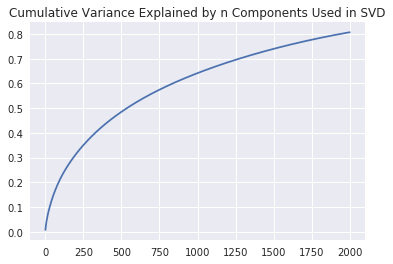

In [29]:
# LSA to reduce dimensionality to something more reasonable
svd= TruncatedSVD(2000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
cum_variance = np.cumsum(variance_explained)

plt.plot(np.arange(1,2001),cum_variance)
plt.title("Cumulative Variance Explained by n Components Used in SVD")
plt.show()

In [7]:
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

Let's arbitrarily use 100 features for performance reasons, but it's worth noting that we're missing a lot of variance by limiting components this strictly.

# Clustering

The next step is to get into some clustering! Even though clustering is an unsupervised method, we are lucky in that we have some output labels (author) to which to compare the clusters we're producing. We'll use the adjusted rand score (ARI) to compare the author categorization to the clusters we create. In other words, we're trying to create clusters that reproduce the authors.

### K-means

In [8]:
from sklearn.cluster import KMeans

Y_pred = KMeans(n_clusters=10, random_state=11).fit_predict(X_train_lsa)

In [9]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0          0    1    2     3    4     5    6     7    8    9
row_0                                                           
bible         12  765  155   589   46  1057    8   127  735  639
blake         17    8    3   134    0     3   24    95    0   32
bryant        61   19  228  1060   72    31  398   282    4    7
burgess       10    0   19   557   19     0  134    52    0    0
chesterton   227   30  392  1650  550    19   89   660    9    6
edgeworth     71   68  411  2711  207    43  153   318   89    5
melville     238   29  127  2235  174    18  112  1110   17   71
milton        50   81   11   320   54    31    0   568    7  281
shakespeare   30   38    4  1041   46    15    5   128   26   82
whitman       64   89   11  1427  114    42   42  1226    5  169


In [10]:
from sklearn import metrics

metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.054580016576421683

Our ARI score, along with a quick look at the crosstab, indicates that our clusters are not that different from a random selection, and are certainly far from accurately grouping the different authors' works. Let's see if we can get a sense of what these clusters do represent instead.

In [13]:
text_and_clusters = pd.DataFrame({'text':X_train, 'cluster':Y_pred})

In [14]:
for clust in np.arange(1,11,1):
    print(text_and_clusters[text_and_clusters['cluster'] == clust].head(10))

       cluster                                               text
5014         1  and they took up the ark of the covenant and w...
13412        1  as they went sailing down ludgate hill evan sa...
11311        1  certainly said turnbull and went outside with ...
26588        1  before him power divine his way prepared at hi...
8835         1  by the stable wherein lay the christ child sto...
1974         1  and moses went down from the mount unto the pe...
14255        1  quite so quite so and with courteous gestures ...
717          1  and jacob went out from beersheba and went tow...
5488         1  and the house of joseph they also went up agai...
3512         1  and the cloud of the lord was upon them by day...
       cluster                                               text
21123        2                          jonah that's another stab
22270        2  but even granting the charge in question to be...
33531        2                             heave the anchor short
33515     

The topical categorization of the different texts surfaces some commonalities. For example one cluster makes frequent mentions of "Moses" and "lord," which are common biblical terms. This makes sense since the bible contributes most heavily to this cluster in terms of membership.

Let's formalize this process a little bit more though, and look at the top keywords per cluster in mean tfidf score.

In [126]:
# Create a DF with the cluster and each of the doc vectors, but named
tfidf_names = pd.DataFrame(X_train_tfidf.todense(),columns=vectorizer.get_feature_names())
tfidf_names['cluster'] = Y_pred
tfidf_names = tfidf_names.groupby('cluster').mean().T

# Function to return top 10 by specified cluster, to reduce print space
def top_tfidf_terms(clust,df):
    return df.sort_values(by=clust,ascending=False)[clust][0:19]

In [117]:
tfidf_names.head()

cluster,0,1,2,3,4,5,6,7,8,9
aaron,0.000133,0.005579,0.0,0.000250,0.000000,0.016098,0.000000,0.000044,0.018854,0.003732
abandoned,0.000392,0.000000,0.0,0.000024,0.000000,0.000000,0.000000,0.000171,0.000000,0.000116
abashed,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000496,0.000356,0.000000,0.000000
abated,0.000000,0.000263,0.0,0.000066,0.000000,0.000193,0.000000,0.000104,0.000000,0.000000
abbey,0.000000,0.000421,0.0,0.000725,0.000287,0.000000,0.000321,0.000271,0.000472,0.000000


In [119]:
# Input different clusters to output top tfidf terms
top_tfidf_terms(5,tfidf_names)

children    0.087017
unto        0.086061
son         0.062056
israel      0.061723
moses       0.038774
sons        0.029486
land        0.028940
tribe       0.021799
went        0.020182
came        0.020122
families    0.020114
jacob       0.018606
lord        0.017875
joseph      0.017237
egypt       0.016336
took        0.016253
cities      0.016131
aaron       0.016098
saying      0.015697
Name: 5, dtype: float64

This just helps to further clarify what we noticed above, which is that clusters are picking up on certain topical themes. The extent to which cluster 5 for example picks up on biblical themes is particularly striking (note: results vary from what you see above due to being run in different sessions).

In [55]:
from sklearn.cluster import KMeans
n_clusters = 20

Y_pred = KMeans(n_clusters=n_clusters, random_state=11).fit_predict(X_train_lsa)

In [56]:
for clust in np.arange(1,n_clusters+1,1):
    print(text_and_clusters[text_and_clusters['cluster'] == clust].head(10))

       cluster                                               text
173          1  and he stayed yet other seven days and again h...
26410        1  thus adam made request and raphael after short...
5927         1  once a youthful pair filled with softest care ...
167          1  and the waters prevailed upon the earth an hun...
33227        1                                wonderful to depart
33531        1                             heave the anchor short
14604        1  in many sceptical papers and magazines afterwa...
32836        1  the threads that were spun are gather'd the we...
33635        1              the rounded catalogue divine complete
17193        1                                      a fatal error
       cluster                                               text
21069        2  in black distress i called my god when i could...
21123        2                          jonah that's another stab
22270        2  but even granting the charge in question to be...
23908     

Neither decreasing or increasing the number of clusters seems to produce more intelligible results.

Given the many nuances of these different texts and how they could be differentiated, it could be worthwhile to try to use a clustering method that works with non-globular data and can work with an undetermined number of clusters, like affinity propagation or mean-shift.

### Mean Shift

In [49]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Using sklearn's bandwidth function to derive a useful value for this parameter
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.5, n_samples=1000)

# Declare and fit the model.. I experimented with various bandwidth values because the bandwidth function suggested a value
# That only produced 1 cluster
ms = MeanShift(bandwidth=0.2, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 6


In [50]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, labels))

Comparing k-means clusters against authors:
col_0           0    1   2   3   4   5
row_0                                 
bible        4133    0   0   0   0   0
blake         316    0   0   0   0   0
bryant       2161    0   0   0   0   1
burgess       791    0   0   0   0   0
chesterton   3632    0   0   0   0   0
edgeworth    3965    0   1  70   0  40
melville     4058    0  70   1   0   2
milton       1399    0   0   0   0   4
shakespeare  1277  100   0   0  38   0
whitman      3181    0   0   1   0   7


This doesn't serve our purposes either, since it is not able to derive very many clusters and does not seem to notice any differentiation between authors. It groups nearly every work into the first cluster, which is also not particularly useful.

### Affinity Propagation
Below is code to run affinity propagation - unfortunately, I was unable to get this algorithm to run in a reasonable amount of time.

In [51]:
svd= TruncatedSVD(25)
lsa_reduced = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa_reduced = lsa.fit_transform(X_train_tfidf)

In [ ]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X_train_lsa_reduced)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

### Spectral Clustering
Since affinity and mean-shift didn't work any better, let's try another fixed output clustering method -- spectral.

In [120]:
from sklearn.cluster import SpectralClustering
n_clusters = 10 

sc = SpectralClustering(n_clusters=n_clusters, random_state=11)
Y_pred = sc.fit_predict(X_train_lsa)

In [60]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0           0    1     2    3     4    5    6    7    8    9
row_0                                                           
bible         811  605   117    5  1775    0  672   42   95   11
blake         128   24   115   23     3    0    7    2    2   12
bryant       1226    6   316  325    56    9   15   99   60   50
burgess       617    0    42  114     3    0    0   10    0    5
chesterton   2381    4   646   56    34    7   28   83  190  203
edgeworth    3293    3   298  103    97    3   51  114   69   45
melville     2232   59   919   75    42  449   22   44  118  171
milton        429  256   558    0    18    1   58    5   37   41
shakespeare  1123   68   110    5    27    1   32    4   19   26
whitman      1530  148  1230   29    48    3   73    4   73   51


In [61]:
metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.060285820811467758

In [62]:
text_and_clusters = pd.DataFrame({'text':X_train, 'cluster':Y_pred})

In [63]:
for clust in np.arange(1,11,1):
    print(text_and_clusters[text_and_clusters['cluster'] == clust].head(10))

       cluster                                               text
27101        1  was she thy god that her thou didst obey befor...
2287         1  and two golden rings shalt thou make to it und...
32945        1                   thou mother with thy equal brood
862          1  this twenty years have i been with thee thy ew...
1995         1                     thou shalt not commit adultery
3652         1  or for a ram thou shalt prepare for a meat off...
26301        1  then when i am thy captive talk of chains prou...
4755         1  and thou shalt write upon the stones all the w...
26879        1  thou never from that hour in paradise foundst ...
2273         1  and thus shalt thou do unto aaron and to his s...
       cluster                                               text
173          2  and he stayed yet other seven days and again h...
26410        2  thus adam made request and raphael after short...
5927         2  once a youthful pair filled with softest care ...
167       

And again let's look at the top tfidf terms.

In [121]:
# Create a DF with the cluster and each of the doc vectors, but named
tfidf_names = pd.DataFrame(X_train_tfidf.todense(),columns=vectorizer.get_feature_names())
tfidf_names['cluster'] = Y_pred
tfidf_names = tfidf_names.groupby('cluster').mean().T

In [123]:
# Input different clusters to output top tfidf terms
top_tfidf_terms(2)

earth     0.015881
sea       0.015810
heaven    0.010180
ship      0.009991
night     0.009796
far       0.008961
air       0.007714
light     0.007674
soul      0.006926
stood     0.006808
eyes      0.006353
sun       0.006109
head      0.006043
long      0.006034
high      0.005826
new       0.005548
great     0.005514
till      0.005354
round     0.005289
Name: 2, dtype: float64

I think the spectral clustering is most useful of the bunch, with k-means not far behind. It at least seems to be identifying unique words & themes among the data. For example, cluster 2 in this instance seems to be picking up on natural themes like earth/sea/air/night/etc. Interesting stuff!

Let's see if there's some visual information that can be conveyed by reducing the information to two dimensions. 

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


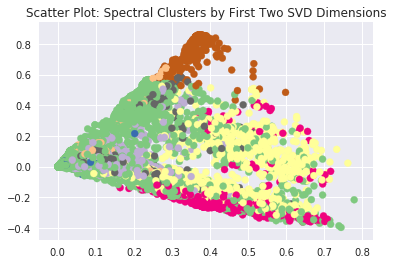

In [67]:
# Plotting the information
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=Y_pred,cmap='Accent')
plt.title("Scatter Plot: Spectral Clusters by First Two SVD Dimensions")
plt.show()

As we can see, there's not much rhyme or reason to the clusters we've created that are visually apparent, at least along the first two SVD dimensions. This is not particularly surprising given that we know that there is major overlap between the clusters and that the first two LSA components only account for a very small fraction of the overall variance in the text data.

Let's see if it produces consistent results on the test set.

In [124]:
# Vectorizing test data per our training set
X_test_tfidf = vectorizer.transform(X_test)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

In [125]:
Y_pred_test = sc.fit_predict(X_test_lsa)

In [104]:
text_and_clusters = pd.DataFrame({'text':X_test, 'cluster':Y_pred_test})

In [105]:
for clust in np.arange(1,11,1):
    print(text_and_clusters[text_and_clusters['cluster'] == clust].head(10))

       cluster                                               text
2399         1  thrice in the year shall all your menchildren ...
5505         1  and it came to pass when the angel of the lord...
1390         1  and joseph made it a law over the land of egyp...
26871        1  so spake the patriarch of mankind but eve pers...
3110         1  and moses declared unto the children of israel...
1980         1  and the lord came down upon mount sinai on the...
3048         1  and moses told it unto aaron and to his sons a...
3414         1  and the lord spake unto moses saying speak unt...
4111         1  and the lord's anger was kindled the same time...
1133         1  and joseph came in unto them in the morning an...
       cluster                                               text
26286        2    to which the fiend thus answered frowning stern
32134        2  lo high toward heaven this day libertad from t...
12           2                and god called the firmament heaven
29660     

In [128]:
# Create a DF with the cluster and each of the doc vectors, but named
tfidf_names_test = pd.DataFrame(X_test_tfidf.todense(),columns=vectorizer.get_feature_names())
tfidf_names_test['cluster'] = Y_pred_test
tfidf_names_test = tfidf_names_test.groupby('cluster').mean().T

In [132]:
# Input different clusters to output top tfidf terms
top_tfidf_terms(5,tfidf_names_test)

thou      0.220856
thee      0.124512
thy       0.121076
shalt     0.107090
unto      0.036606
shall     0.033515
hast      0.029166
god       0.028071
art       0.026647
lord      0.024163
thine     0.019917
said      0.019659
make      0.017009
land      0.012492
st        0.012246
people    0.011756
come      0.010470
eat       0.010214
let       0.010083
Name: 5, dtype: float64

The clustering seems to be working similarly on the test set by, for example, having a cluster that groups common biblical terms.

### Spectral Clustering Using Lemmas
Perhaps we can produce even more interesting clusters when we use lemmas the token to be vectorized. Let's see how the clusters change when relying on lemmas.

In [133]:
literature_lemmas = pd.read_pickle("literature_lemmas.pkl")
X_lemmas = literature_lemmas['text']
Y_lemmas = literature_lemmas['author']

In [134]:
# Reserving 25% as a training set
from sklearn.model_selection import train_test_split

X_lemmas = literature_lemmas['text']
Y_lemmas = literature_lemmas['author']

X_train_lemmas, X_test_lemmas, Y_train_lemmas, Y_test_lemmas = train_test_split(X_lemmas, Y_lemmas, test_size=0.25, random_state=11)

In [135]:
# tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf_lemma = vectorizer.fit_transform(X_train_lemmas)
print(X_train_tfidf_lemma.shape)

(25248, 5947)


In [136]:
# Again truncating to 100 features via LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa_lemma = lsa.fit_transform(X_train_tfidf_lemma)

In [137]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10)
Y_pred_lemma = sc.fit_predict(X_train_lsa_lemma)

In [91]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0           0    1     2    3     4    5    6    7    8    9
row_0                                                           
bible         811  605   117    5  1775    0  672   42   95   11
blake         128   24   115   23     3    0    7    2    2   12
bryant       1226    6   316  325    56    9   15   99   60   50
burgess       617    0    42  114     3    0    0   10    0    5
chesterton   2381    4   646   56    34    7   28   83  190  203
edgeworth    3293    3   298  103    97    3   51  114   69   45
melville     2232   59   919   75    42  449   22   44  118  171
milton        429  256   558    0    18    1   58    5   37   41
shakespeare  1123   68   110    5    27    1   32    4   19   26
whitman      1530  148  1230   29    48    3   73    4   73   51


In [92]:
from sklearn import metrics

metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.060285820811467758

In [93]:
text_and_clusters = pd.DataFrame({'text':X_train_lemmas, 'cluster':Y_pred})

In [94]:
for clust in np.arange(1,11,1):
    print(text_and_clusters[text_and_clusters['cluster'] == clust].head(10))

       cluster                                               text
27101        1                     thy god thou didst obey voice 
2287         1  golden ring shalt thou crown corner thereof si...
32945        1                       thou mother thy equal brood 
862          1  year thee thy ewe thy goat cast young ram thy ...
1995         1                        thou shalt commit adultery 
3652         1  ram thou shalt prepare meat offer tenth deal f...
26301        1      thy captive talk chain proud limitary cherub 
4755         1           thou shalt write stone word law plainly 
26879        1  thou hour paradise foundst sweet repast sound ...
2273         1  shalt thou unto aaron son accord thing command...
       cluster                                               text
173          2  stay seven day send forth dove ark dove come e...
26410        2     adam request raphael short pause assent begin 
5927         2  youthful pair fill soft care meet garden brigh...
167       

In [138]:
# Create a DF with the cluster and each of the doc vectors, but named
tfidf_names_lemma = pd.DataFrame(X_train_tfidf_lemma.todense(),columns=vectorizer.get_feature_names())
tfidf_names_lemma['cluster'] = Y_pred
tfidf_names_lemma = tfidf_names_lemma.groupby('cluster').mean().T

In [141]:
# Input different clusters to output top tfidf terms
top_tfidf_terms(2,tfidf_names_lemma)

sea       0.016763
earth     0.016449
ship      0.011778
heaven    0.011212
night     0.010617
light     0.009564
far       0.009151
stand     0.009080
eye       0.008316
water     0.008149
fall      0.008064
air       0.008003
soul      0.007497
high      0.007414
head      0.007393
open      0.007365
great     0.006809
sun       0.006451
long      0.006319
Name: 2, dtype: float64

It is hard to say whether the lemmas vectorization is producing better clusters, as qualitatively the ones it produces are somewhat similar (one related to nature (sea/earth/night), another for biblical terms, etc.). Which one is preferable will be situational and depend on the specific aims of your research question.

Let's move on to supervised learning.

# Supervised Learning
We'll rely on the LSA exercise we relied on previously. Let's first take a quick look at what constitutes each component.

Our key metric will be overall classification accuracy, versus a baseline of guessing the mode (The Bible).

Let's start with vanilla versions of various classifiers to see where that gets us. 

### LSA Models

In [5]:
# Repeating vectorization and LSA in case not running previous cells
from sklearn.model_selection import train_test_split

X = literature['text']
Y = literature['author']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)

svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

X_test_tfidf = vectorizer.transform(X_test)
X_test_lsa = lsa.transform(X_test_tfidf)

In [8]:
# Establishing baseline of just guessing mode (bible)
Y.value_counts().max()/len(Y)

0.1665230952027328

In [236]:
# Instantiating vanilla versions of each model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics

lrc = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
svc = SVC()

In [22]:
models = {'Logistic Regression':lrc,'Random Forest':rfc,'Gradient Boosted Classifier':gbc,'Support Vector Machine':svc}
accuracies = []

for key in models:
    # fit & predict
    models[key].fit(X_train_lsa,Y_train)
    Y_test_pred = models[key].predict(X_test_lsa)
    # test accuracy
    accuracy = metrics.accuracy_score(Y_test, Y_test_pred)
    print("{} Accuracy Score on Test Set: {}".format(key,accuracy))
    accuracies.append(accuracy)

Logistic Regression Accuracy Score on Test Set: 0.5852441487465843
Random Forest Accuracy Score on Test Set: 0.5372460496613995
Gradient Boosted Classifier Accuracy Score on Test Set: 0.5876202922656528
Support Vector Machine Accuracy Score on Test Set: 0.5341570630866105


Of course, these models could each be optimized in their own ways, but it's interesting to note that they all perform relatively similarly out of the box. Each is struggling to generate accuracy far above 50% on our test set observations. Granted, this is a very tough problem, so guessing half of passages based purely on their text is pretty good! But there's some things we can experiment with beyond just the usual fine tuning of models, which we'll save for last. For one, we can exclude paragraphs from training and test that do not meet a certain length. Let's try that.

### Modeling on a subsetted dataset to exclude short paragraphs

In [6]:
# Applying func to add column word counts to df
def count_words(string):
    return len(string.split())
literature['word_count'] = literature['text'].apply(count_words)

# New DF with only paragraphs longer than five words
literature_longersents = literature[literature['word_count'] > 5]

X_long = literature_longersents['text']
Y_long = literature_longersents['author']

# Redoing train test split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_long, Y_long, test_size=0.25, random_state=11)

# Vectorizing and performing LSA
X_train_long_tfidf = vectorizer.fit_transform(X_train2)
X_train_long_lsa = lsa.fit_transform(X_train_long_tfidf)

X_test_long_tfidf = vectorizer.transform(X_test2)
X_test_long_lsa = lsa.transform(X_test_long_tfidf)

In [24]:
# Rerunning our models with the new data
for key in models:
    # fit & predict
    models[key].fit(X_train_long_lsa,Y_train2)
    Y_test_pred = models[key].predict(X_test_long_lsa)
    # test accuracy
    accuracy = metrics.accuracy_score(Y_test2, Y_test_pred)
    print("{} Accuracy Score on Test Set: {}".format(key,accuracy))
    accuracies.append(accuracy)

Logistic Regression Accuracy Score on Test Set: 0.6398104265402843
Random Forest Accuracy Score on Test Set: 0.5311018957345972
Gradient Boosted Classifier Accuracy Score on Test Set: 0.6132997630331753
Support Vector Machine Accuracy Score on Test Set: 0.5848637440758294


Interesting. This improved the quality of most of our models and substantially for some. To experiment further with the predictive value of different input variables, let's even try using just the TFIDF vectorization itself as model.

### TFIDF Models

In [26]:
# Rerunning our models with the new data
for key in models:
    # fit & predict
    models[key].fit(X_train_long_tfidf,Y_train2)
    Y_test_pred = models[key].predict(X_test_long_tfidf.toarray())
    # test accuracy
    accuracy = metrics.accuracy_score(Y_test2, Y_test_pred)
    print("{} Accuracy Score on Test Set: {}".format(key,accuracy))
    accuracies.append(accuracy)

Logistic Regression Accuracy Score on Test Set: 0.7852488151658767
Random Forest Accuracy Score on Test Set: 0.654324644549763
Gradient Boosted Classifier Accuracy Score on Test Set: 0.6627665876777251
Support Vector Machine Accuracy Score on Test Set: 0.20927132701421802


All of our models seem to again improve with the exception of SVM, which seems to be unable to handle the large dimensional feature space. The logistic regression has leapt to the front of the pack. I suspect that this is because the L2 regularization it applies allows it to effectively handle the many many features we're now throwing at it. At 78.5% accuracy, we're really starting to approach a quite effective model. Let's gridsearch to optimize this regression and squeeze out the remaining performance.

### Optimization of TFIDF Models

In [12]:
from sklearn.model_selection import GridSearchCV

# Defining range of c values to try
c_range = np.append(np.append(np.arange(0.1,1,0.1),np.arange(1,11,1)),np.arange(20,1020,20))

# Parameter grid
parameters = {'penalty':('l1', 'l2'), 'C':[0.11, 10]}

# Run the gridsearch, save & print the best parameters
grid_lr = GridSearchCV(lrc, parameters)
grid_lr.fit(X_train_long_tfidf,Y_train2)
best_params = grid_lr.best_params_
print(best_params)

{'C': 10, 'penalty': 'l2'}


In [13]:
# Test performance on the test set
lrc = LogisticRegression(**best_params)
lrc.fit(X_train_long_tfidf,Y_train2)
Y_test_pred = lrc.predict(X_test_long_tfidf)
accuracy = metrics.accuracy_score(Y_test2, Y_test_pred)
print("Optimized LR Accuracy Score on Test Set: {}".format(accuracy))

Optimized LR Accuracy Score on Test Set: 0.803021327014218


We're able to get to 80% accuracy. That's not bad at all! Let's see how much we can optimize the random forest.

In [97]:
from sklearn.model_selection import GridSearchCV

# Defining range of values to try (done successively)
est_range = np.arange(80,110,10)

# Parameter grid
parameters = {'n_estimators':est_range
              , 'min_samples_split':[2,5,10]
             ,'max_depth':[None,5,10,20,100]}

# Run the gridsearch, save & print the best parameters
grid_rfc = GridSearchCV(rfc, parameters)
grid_rfc.fit(X_train_long_tfidf,Y_train2)
best_params = grid_rfc.best_params_
print(best_params)

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [98]:
# Test performance on the test set
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train_long_tfidf,Y_train2)
Y_test_pred = rfc.predict(X_test_long_tfidf)
accuracy = metrics.accuracy_score(Y_test2, Y_test_pred)
print("Optimized LR Accuracy Score on Test Set: {}".format(accuracy))

Optimized LR Accuracy Score on Test Set: 0.7023104265402843


This could probably be optimized further with other parameters, but I've limited the number used due to computing constraints. In any event, logistic regression still seems to perform better than the random forest model. Gradient boosted classification and support vector machines could likely be optimized as well given more time, but gridsearching those was too computationally intensive for this exercise.

Next, let's see if word2vec can provide the basis for a better model.

### Word2Vec

In [8]:
# getting the words to train the model on in the correct format
train_word_list = []
for para in X_train2:
    words = para.split()
    train_word_list.append(words)

In [9]:
# importing gensim and instantiating
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    train_word_list,
    workers=4,     
    min_count=10,  
    window=6,      
    sg=0,          
    sample=1e-3 ,  
    size=300,      
    hs=1           
)

print('done!')

done!


In [ ]:
# Creating the word2vec feature space for the training set 
vstack = np.arange(0,300)
for para in X_train2:
    vector = []
    wordlist = para.split()
    for word in wordlist:
        if word in model.wv:
            vector.append(model.wv[word])
    if len(vector) != 0:
        vector_sums = np.sum(np.array(vector),axis=0)
    else:    
        vector_sums = np.repeat(0,300)
    vstack = np.vstack([vstack,vector_sums])

In [227]:
# And the same for the test set (separated out since it takes a while to run)
vstack_test = np.arange(0,300)
for para in X_test2:
    vector = []
    wordlist = para.split()
    for word in wordlist:
        if word in model.wv:
            vector.append(model.wv[word])
    if len(vector) != 0:
        vector_sums = np.sum(np.array(vector),axis=0)
    else:    
        vector_sums = np.repeat(0,300)
    vstack_test = np.vstack([vstack_test,vector_sums])

In [242]:
from sklearn.preprocessing import normalize

train_word2vec = pd.DataFrame(data=vstack[1:],columns=vstack[0])
test_word2vec = pd.DataFrame(data=vstack_test[1:],columns=vstack_test[0])

train_word2vec, test_word2vec = normalize(train_word2vec),normalize(test_word2vec)

pd.DataFrame(train_word2vec).to_pickle("train_word2vec.pkl")
pd.DataFrame(test_word2vec).to_pickle("test_word2vec.pkl")

OK, now we've created the word2vec feature space. Let's run our models from before and see how they do.

In [240]:
normalize(train_word2vec).shape

(20256, 300)

In [246]:
models = {'Logistic Regression':lrc,'Random Forest':rfc,'Gradient Boosted Classifier':gbc,'Support Vector Machine':svc}

for key in models:
    # fit & predict
    models[key].fit(train_word2vec,Y_train2)
    Y_test_pred = models[key].predict(test_word2vec)
    # test accuracy
    accuracy = metrics.accuracy_score(Y_test2, Y_test_pred)
    print("{} Accuracy Score on Test Set: {}".format(key,accuracy))

Logistic Regression Accuracy Score on Test Set: 0.6272215639810427
Random Forest Accuracy Score on Test Set: 0.5546504739336493
Gradient Boosted Classifier Accuracy Score on Test Set: 0.6229265402843602
Support Vector Machine Accuracy Score on Test Set: 0.529324644549763


Interesting! Word2Vec did pretty well with the data, about the same range of accuracy as we saw from our original LSA models with default parameters. This could probably be improved through some optimization, but the real added value from word2vec could come from bringing in a pretrained model, since we know this technique typically is most effective when trained on an extremely large corpus (which ours is not).

Out of curiosity, below I tried some of our original models with lemmas instead of word tokens. This didn't yield particularly useful results.

### Modeling on Lemmas

In [83]:
literature_lemmas = pd.read_pickle("literature_lemmas.pkl")

In [84]:
# Reserving 25% as a training set
from sklearn.model_selection import train_test_split

X_lemmas = literature_lemmas['text']
Y_lemmas = literature_lemmas['author']

X_train_lemmas, X_test_lemmas, Y_train_lemmas, Y_test_lemmas = train_test_split(X_lemmas, Y_lemmas, test_size=0.25, random_state=11)

In [85]:
# tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf_lemmas = vectorizer.fit_transform(X_train_lemmas)

svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa_lemmas = lsa.fit_transform(X_train_tfidf_lemmas)

X_test_tfidf_lemmas = vectorizer.transform(X_test_lemmas)
X_test_lsa_lemmas = lsa.transform(X_test_tfidf_lemmas)

In [90]:
# Rerunning our models with the new data
for key in models:
    # fit & predict
    models[key].fit(X_train_lsa_lemmas,Y_train_lemmas)
    Y_test_pred = models[key].predict(X_test_lsa_lemmas)
    # test accuracy
    accuracy = metrics.accuracy_score(Y_test_lemmas, Y_test_pred)
    print("{} Accuracy Score on Test Set: {}".format(key,accuracy))
    accuracies.append(accuracy)

Logistic Regression Accuracy Score on Test Set: 0.5845313056908638
Random Forest Accuracy Score on Test Set: 0.5288107401687062
Gradient Boosted Classifier Accuracy Score on Test Set: 0.5833432339313295
Support Vector Machine Accuracy Score on Test Set: 0.5278602827610788


Using lemmas has very similar results to our first run of supervised models and may not represent much of an improvement.

# Concluding Thoughts
This has been a very educational exercise. Here's a rundown of what we observed when working with the Gutenberg corpus.
- Clustering produced mixed results. We weren't able to differentiate by author in the way we had hoped, but we were able to unearth some interesting topical clusterings.
    - K means and spectral clustering produced the most interpretable results.
    - Using lemmas instead of word tokens arguably made the clusters a bit easier to understand to the naked eye.
- Supervised models had a much more useful application to the question of grouping passages by authors, and we were able to produce several fairly accurate models.
- Our most accurate model on the test set was an L2 logistic regression based on the tfidf vectorization (without LSA) on paragraphs longer than 5 words, which was further grid-search optimized.
    - In general, expanding to tfidf instead of using LSA improved performance, particularly for this logistic regression model.
    - Excluding short paragraphs also helped improve the accuracy and applicability of our models, as the most common real world application would likely involve predicting the author based on a passage of at least a few words.
    - Word2vec showed promise as a technique, but for better results we'd want to bring in a pretrained model informed by a much larger corpus.
    - Stemming tokens showed limited impact on predictive value in our application.